<center>
    <h1>
        Spatial GCN for Node Feature Estimation in Water Distribution Systems
    </h1>
    <h2>   
        A PyTorch Geometric Replication Study on L-Town
    </h2>
    <i>
        Author: Elisa Scandiuzzi (ID: 2069444)
    </i>
</center>

## Project aim and selected paper with a brief description.








The main objective of this project is to deepen the study of graph neural networks (GNNs) applied to real-world scenarios, such as water distribution systems (WDS), through the reimplementation of the model proposed in the paper *"Spatial Graph Convolution Neural Networks for
Water Distribution Systems"* by Ashraf et al. (2022).

In the selected paper, the authors propose a model for reconstructing nodal pressure data in a Water Distribution System (WDS) using information from only a subset of nodes.

This problem is particularly relevant since data acquisition in WDSs is essential for measurement-dependent models used in optimal pump scheduling, water demand forecasting, and attack or leakage detection. The effectiveness of these models depends heavily on the quantity and quality of real-time measurement data, particularly nodal pressures. However, collecting and processing data from a WDS is complex for two main reasons: the data is located on an irregular grid and is only partially observable.  


To manage non-Euclidean data like WDS, geometric deep learning techniques are more suitable. Specifically, the model proposed by the authors implements a graph neural network (GNN) based on a message passing architecture, with a multi-hop variation designed to reduce the resources needed while maintaining high reconstruction accuracy.



## Reproducibility instructions and libreries

The following code was executed on Google Colab. To reproduce the results, upload the project folder to Google Drive and modify the path stored in the **project_folder** variable accordingly.

It is necessary to import the wtnr and geometric_pytorch libraries. Note that version-related warnings for NumPy may appear. If this occurs, restart the Colab session and rerun the code.



In [1]:
!pip install wntr --quiet
!pip install torch_geometric --quiet
#Note: When running the notebook in Google Colab, it may be necessary to restart the runtime to use installed libreries.

In [4]:
# water network tool for resilience, to read .inp file
import wntr

from google.colab import drive
import os

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from datetime import datetime


# For iteration bars
from tqdm.notebook import tqdm

# for garbage collector
import gc


# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# torch_geometric
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing



In [5]:
drive.mount('/content/drive')

# Drive path
project_folder = '/content/drive/MyDrive/Neural_networks/Project/' ## To change with actual position in Drive

# Change directory
os.chdir(project_folder)
print("The current directory is:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The current directory is: /content/drive/MyDrive/Neural_networks/Project


## Theoretical background and key concepts.

The following section presents the theoretical concepts necessary for understanding the subsequent model.

### Graph Theory

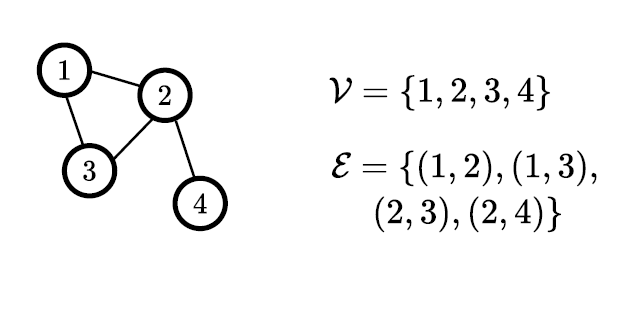


A graph is a mathematical object defined by a pair of sets $G(V,E)$:


*   the set $V = \{1, 2, \dots, n\}$ called the set of nodes;
*   the set $E \subseteq [V]^2 = \{ (u, v) | \exists u, v  \in V\}$ called the set of edges.

Graphs provide an effective way to model a wide range of real-world networks, including hydraulic infrastructures, gas distribution systems, and social networks.

A graph where the connections are always bidirectional  ($(u,v) \in E \implies (v,u) \in E $) is called undirected, otherwise is called directed.

Given a graph $G(V, E)$ and a node $v \in V$, we define the 1-hop neighborhood as:

$$\mathcal{N}(i) = \{j \mid (i, j) \in \mathcal{E}\}.$$
It is the set of nodes that are directly connected to the node by an edge, it represents all nodes that can be reached from the given node in a single step.



### Message passing

Graph Neural Networks (GNN) are artificial neural networks specialized on graph data. A key component of GNNs is the message-passing process, enabling nodes to iteratively update their feature representations by aggregating information from their local neighborhoods.

A generic Message passing layer is defined as:
$\mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \bigoplus_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right)$
where


*   $\bigoplus$ represent a differentiable, permutation invariant function, e.g., sum, mean or max,
*   and $\gamma$ and $\phi$ denote differentiable functions such as MLPs (Multi Layer Perceptrons).




## Implementation details: dataset, models, experimental setup.


In [6]:
# # PARAMETERS

# # Experiment 1
# N_GCN_LAYERS = 10
# MULTIHOP = 1
# N_MLP_LEVELS = 2
# latent_dim = 96

# Experiment 2
N_GCN_LAYERS = 10
MULTIHOP = 5
N_MLP_LEVELS = 2
latent_dim = 96


# Optim
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
EPOCHS = 600

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)


device: cuda


In [7]:
# Paths reference

pressure_data_path ="./Data/Measurements_All_Pressures.csv"
root_dataset_path = "./Data/dataset/"
root_dataset_path_train = root_dataset_path + "train"
root_dataset_path_val = root_dataset_path + "val"
root_dataset_path_test = root_dataset_path + "test"
root_dataset_path_after = root_dataset_path + "after"
CHECKPOINTS_PATH = "./Model"

# Dataset

The L-Town dataset represents a water distribution system model originally developed as a benchmark for BattleDim, Battle of the Leakage Detection and Isolation Methods.
The network is a modified version of a real system located in a coastal town in Cyprus and comprises 782 junctions and 905 pipe segments, each approximately 50 metres long. The system is designed to supply drinking water to approximately 10,000 consumers and industries.

In the L-TOWN.inp file, the network data is provided, from which relevant information regarding nodes and pipes can be extracted, including the network topology, pipe lengths, and diameters.








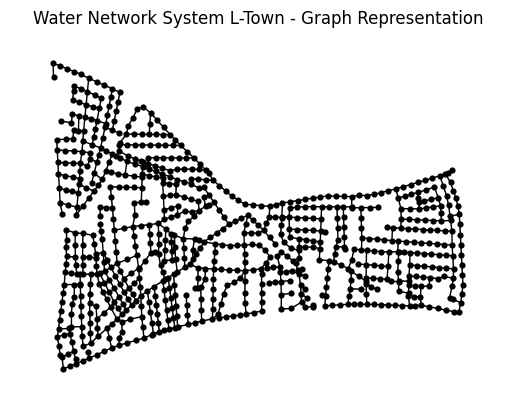

In [8]:
# File path
inp_file_path = "./Data/L-TOWN.inp"

# Create a water network model
wn_model = wntr.network.WaterNetworkModel(inp_file_path)

# Plot graph
pos = wntr.graphics.plot_network(wn_model, title="Water Network System L-Town - Graph Representation")

In [9]:
wn_dict = wntr.network.to_dict(wn_model)

# Extract relevant data - NODES
nodes_df = pd.DataFrame(wn_dict["nodes"])
nodes_df = nodes_df[['name', 'node_type', 'base_demand', 'elevation']].fillna(0)

# Add index in range [0, num_nodes]
nodes_df['node_id'] = range( len(nodes_df))

mapping = dict(zip(nodes_df["name"], nodes_df['node_id'])) #map "name_node": id_node
number_nodes = len(mapping)


# Extract relevant data - EDGES
links_df = pd.DataFrame(wn_dict["links"])
links_df = links_df[['name', 'link_type', 'start_node_name', 'end_node_name', 'diameter', 'initial_setting', 'length']].fillna(0)

# replace node names with indices in mapping
links_df['start_node_name'] = links_df['start_node_name'].replace(mapping)
links_df['end_node_name'] = links_df['end_node_name'].replace(mapping)


# Replace text data (type of nodes and edges) with numbers
mapping_nodes_type = {'Junction':0, 'Reservoir':1, 'Tank':2}
nodes_df['node_type'] = nodes_df['node_type'].replace(mapping_nodes_type)

mapping_edge_type = {'Pipe':0, 'Pump':1, 'Valve':2}
links_df['link_type'] = links_df['link_type'].replace(mapping_edge_type)



/tmp/ipython-input-3992951498.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  links_df['start_node_name'] = links_df['start_node_name'].replace(mapping)
/tmp/ipython-input-3992951498.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  links_df['end_node_name'] = links_df['end_node_name'].replace(mapping)
/tmp/ipython-input-3992951498.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To 

---
The **pressure data** was generated using the [generator](https://github.com/HammerLabML/GCNs_for_WDS/blob/main/dataset_generator.py) provided by the authors in the code related to the article.
The data is generated  using [wntr](https://usepa.github.io/WNTR/), an EPANET compatible Python package designed to simulate and analyze resilience of water distribution networks, to compute node-level data over a three-month period. The samples were generated at 15-minute intervals, resulting in 96 samples per day.

The same data subdivision used by the authors was employed: one month of data (2,880 samples) was used for training, while the following two months (5,760 samples) were used for evaluation. The training data was further divided into train, validation, and test sets in a 60-20-20 ratio.



In [10]:
# Load data of pressures
pressures_df = pd.read_csv(pressure_data_path)
print(pressures_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Columns: 786 entries, Timestamp to T1
dtypes: float64(785), object(1)
memory usage: 155.4+ MB
None


In [11]:
class DataLoadHelper():
    def __init__(self):
        # Save mean and std of normalized data for conversion
        self.mean_pressures = None
        self.std_pressures = None
        self.mean_edges = None
        self.std_edges = None

    # Load Pressure data
    def load_data(self, pressure_data_path, selection, print_info=True):
        '''
        pressure_data_path: path of csv data of pressures
        mode: dataset desired:
            -if train_val return train and validation dataset (60% and 20% of 1st month),
            -if test return test dataset (last 20% of 1st month),
            -if second_period return 2nd and 3rd months.
        '''
        pressures_df = pd.read_csv(pressure_data_path).fillna(0)
        n_rows = len(pressures_df)
        first_period = n_rows//3

        if (selection == "second_period"):
            if print_info: print("Selected 2nd and 3rd months.", (n_rows-first_period)//3 , "samples.")
            return pressures_df.iloc[first_period::3]
        else:
            test_start =  (first_period*4)//5
            if (selection == "test"):
                if print_info: print("Selected tets data, 20% of 1st month.", (first_period-test_start)//3 , "samples.")
                return pressures_df.iloc[test_start:first_period:3]
            elif(selection == "train_val"):
                start_val = (first_period*3)//5
                if print_info: print("Selected train data, 60% of 1st month.", (start_val)//3 , "samples.")
                if print_info: print("Selected validation data, 20% of 1st month.", (test_start-start_val)//3 , "samples.")
                train_data_temp, val_data_temp = pressures_df.iloc[:start_val:3], pressures_df.iloc[start_val:test_start:3]
                self.compute_normalization_values_nodes(train_data_temp)
                return train_data_temp, val_data_temp
            else:
                print("Invalid selection")
                return

    def compute_normalization_values_nodes(self, train_data):
        '''
        input dataframe of train values, compute mean and std of pressures, stored as a  pandas series.
        '''
        self.mean_pressures = train_data.iloc[:, 1:].mean() # first column excluded, is timestamp
        self.std_pressures = train_data.iloc[:, 1:].std()
        return

    def normalize_torch_data_nodes(self, tensor_data):
        '''
        input: tensor data, return normalized version
        '''
        mean_tensor = torch.tensor(self.mean_pressures.values, dtype=torch.float32).unsqueeze(0)
        std_tensor = torch.tensor(self.std_pressures.values, dtype=torch.float32).unsqueeze(0)

        X_pytorch_normalized = (tensor_data - mean_tensor) / (std_tensor + 1e-10)
        return X_pytorch_normalized

    def inverse_normalize_torch_data_nodes(self, normalized_tensor_data, device = DEVICE):
        '''
        input: normalized tensor data, return original version
        '''
        mean_tensor = torch.tensor(self.mean_pressures.values, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        std_tensor = torch.tensor(self.std_pressures.values, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        return (normalized_tensor_data * std_tensor + 1e-10)+ mean_tensor

    def normalize_torch_data_edges(self, tensor_data):
        '''
        input: tensor edges data, return normalized version
        '''
        self.mean_edges = torch.mean(tensor_data, dim=0) # first column excluded, is timestamp
        self.std_edges = torch.std(tensor_data, dim=0)
        print(tensor_data.shape, self.mean_edges.shape, self.std_edges.shape)
        X_pytorch_normalized = (tensor_data - self.mean_edges) / (self.std_edges + 1e-10)
        return X_pytorch_normalized





In [12]:
data_load_helper = DataLoadHelper()
train_data, val_data = data_load_helper.load_data(pressure_data_path, "train_val")


Selected train data, 60% of 1st month. 1728 samples.
Selected validation data, 20% of 1st month. 576 samples.


---

The topology data extracted from the .inp file and the pressure data from the .csv file were then combined into a single, customized dataset using the [InMemoryDataset](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets) class. This class, provided by [geometric_pytorch](https://pytorch-geometric.readthedocs.io/en/latest/index.html), is specifically designed for handling small-sized graph datasets that fit in memory.

For each graph, corresponding to a different time step in the simulation, the **node features**, **edge features**, and **edge indices** are stored. Additionally, a masked version of the pressure data is saved, in which all nodes outside a subset assumed to contain sensors are set to zero.

Since the topology and edge attributes are shared across all graphs, they are stored only once to save computational resources and are recalled as needed during processing.


In [17]:
# Define edge index_index tensor, the edges are duplicated in reversed order to consider the undirected data
edge_index = torch.tensor([pd.concat([links_df['start_node_name'], links_df['end_node_name']], ignore_index=True), pd.concat([links_df['end_node_name'], links_df['start_node_name']], ignore_index=True)], dtype = torch.long)

# Edges and nodes features that are equal for all the graphs of the dataset
node_features_static = torch.tensor(nodes_df[['node_type', 'base_demand', 'elevation']].values, dtype=torch.float32)

edges_features = torch.tensor(links_df[[ 'link_type',  'diameter', 'initial_setting', 'length']].values, dtype=torch.float32)


/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


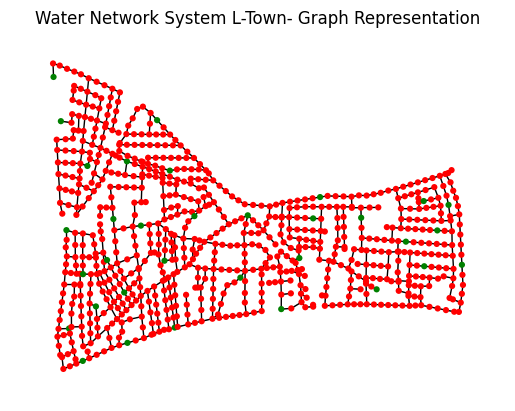

In green the nodes with sensor, in red nodes without sensor


In [16]:
# Nodes where there is data acquisition
pressure_sensors = ['n1', 'n4', 'n31', 'n54', 'n105', 'n114', 'n163', 'n188', 'n215', 'n229', 'n288', 'n296', 'n332', 'n342', 'n410', 'n415', 'n429', 'n458', 'n469','n495', 'n506', 'n516', 'n519', 'n549','n613', 'n636', 'n644', 'n679', 'n722', 'n726', 'n740', 'n752','n769']
pressure_sensors_set = set(pressure_sensors)
color_map = {}
for node_name, node in wn_model.nodes():
    if node_name in pressure_sensors_set:
        color_map[node_name] = "green"
    else:
        color_map[node_name] = "red"

# Representation of the network: in green the nodes with sensors, in red all the others
pos = wntr.graphics.plot_network(wn_model, node_attribute  = color_map, title="Water Network System L-Town- Graph Representation", add_colorbar  = False)
print("In green the nodes with sensor, in red nodes without sensor")

indices_pressure_sensors = [mapping[node_n] for node_n in pressure_sensors] #indices

# Data input of the rest will be set to zero
masked_indices = [ind for ind in range(number_nodes) if ind not in set(indices_pressure_sensors)] #indices of nodes without sensor

# Function to mask data, called during processing of class OptimizedGraphDataset
def create_masked_features(x_original, mask_indices):
    '''
    Given pressures tensor (without the timestamps, only the pressures), and the indices of masked data,
    return a tensor of masked data, each row is a different graph corresponding to a different timestamp, columns correspond to different nodes
    '''
    x_masked = x_original.clone()
    x_masked[:, mask_indices] = 0.0
    return x_masked

In [25]:
class OptimizedGraphDataset(InMemoryDataset):
    def __init__(self, root, df_pressures,  mask_indices, edge_index, edge_attr=None):
        self.df_pressures = df_pressures.fillna(0)
        self.edge_index = edge_index #the same for all the graphs
        self.edge_attr = data_load_helper.normalize_torch_data_edges(edge_attr) #the same for all the graphs
        self.edge_attr = torch.cat([self.edge_attr, self.edge_attr], dim=0)
        self.mask_indices = mask_indices
        super().__init__(root)
        # Load data (2 datasets)
        self.data_masked, self.slices_masked, self.data_gt, self.slices_gt = torch.load(self.processed_paths[0], weights_only=False)


    @property
    def processed_file_names(self):
        return ['saved_data.pt']

    def process(self):
        data_list_masked = []
        data_list_gt = []

        nodes_pressures = torch.tensor(self.df_pressures.iloc[:,1:].values, dtype=torch.float) # tensor, each row contains pressure data of the graph
        nodes_pressures = data_load_helper.normalize_torch_data_nodes(nodes_pressures)
        timestamps_list = self.df_pressures.iloc[:,0] #  strings in format YYYY-MM-DD HH:mm:ss
        timestamps_list = pd.to_datetime(timestamps_list).astype('int64')// 10**9 # convert in Timestamp Unix in nanosec and then in SECONDS
        timestamps_list = torch.tensor(timestamps_list.values, dtype=torch.long)

        masked_pressures = create_masked_features(nodes_pressures, self.mask_indices ) # tensor of masked data

        for single_graph_pressure_data, single_timestamp, single_graph_pressure_data_masked in tqdm(zip(nodes_pressures, timestamps_list, masked_pressures), total=len(timestamps_list),
            desc='Elaborazione Grafi'):

            # Feature Originali
            x_original = single_graph_pressure_data.clone()

            # masked node feature
            x_masked = single_graph_pressure_data_masked.clone()

            timestamp_tensor = single_timestamp.clone()

            # Input Graph: Masked input
            data_input = Data(x=x_masked, time=timestamp_tensor)
            data_list_masked.append(data_input)

            #Ground Truth (Target)
            data_target = Data(x=x_original, time=timestamp_tensor)
            data_list_gt.append(data_target)

        # Collate (Unify)
        data_masked, slices_masked = self.collate(data_list_masked)
        data_gt, slices_gt = self.collate(data_list_gt)

        # add shared data (Edge info)
        data_masked.edge_index = self.edge_index
        data_masked.edge_attr = self.edge_attr
        data_gt.edge_index = self.edge_index
        data_gt.edge_attr = self.edge_attr

        # Save objects
        torch.save((data_masked, slices_masked, data_gt, slices_gt), self.processed_paths[0])

    def __len__(self):
        return self.slices_masked['x'].numel() - 1

    def __getitem__(self, idx):

        data_masked = self._get_single_graph(self.data_masked, self.slices_masked, idx)
        data_gt = self._get_single_graph(self.data_gt, self.slices_gt, idx)

        # recall shared data
        data_masked.edge_index= self.edge_index
        data_masked.edge_attr = self.edge_attr

        data_gt.edge_index = self.edge_index
        data_gt.edge_attr = self.edge_attr

        return {"input":data_masked, "groundtruth":data_gt}

    def _get_single_graph(self, data, slices, idx):
        graph = Data()
        for key in data.keys(): #[x, time]
            item = data[key]  #data of collated graph
            if key in slices:
                s = slices[key]
                start, end = s[idx].item(), s[idx + 1].item()
                graph[key] = item[start:end] if item.dim() > 0 else item
            else:
                graph[key] = item
        return graph

In [26]:
val_dataset = OptimizedGraphDataset(root_dataset_path_val, val_data, masked_indices, edge_index, edges_features)
train_dataset = OptimizedGraphDataset(root_dataset_path_train, train_data, masked_indices, edge_index, edges_features)

torch.Size([909, 4]) torch.Size([4]) torch.Size([4])
torch.Size([909, 4]) torch.Size([4]) torch.Size([4])


# Model

### Data and embedding

A graph of the dataset is represented as $G(V, X, E, F)$, where:

*   $V= \{0, 1, 2 \dots n\}$ is the set of nodes
*    $E = \{e_{vu} \mid \forall v \in V; u \in \mathcal{N}(v)\}$ is the set of edges,
*    $X \in \mathbb{R}^{N \times D}$ is the set of node features, where $N = |V|$ and $D$ is the number of node features,
*   $F \in \mathbb{R}^{M \times K}$ is the set of edge features, where $M = |E|$ and $K$ is the number of edge features.

In addition we have the edge_index tensor of dimensionality $(2, 2\cdot|E|)$ that takes in acocunt of the (undirected) edges.

Node and edge features are embedded by linear layers:

\begin{aligned}
    h_v^{1} &= \text{Linear}_{node}(x_v) && v \in V, \, x_v \in X \\
    h_{e_{vu}}^{1} &= \text{Linear}_{edges}(f_{e_{vu}}) && e_{vu} \in E, \, f_{e_{vu}} \in F
\end{aligned}





### Message Passing mechanism
The message passing mechanism is composed of 3 phases:



1.   **Message generation:**
The messages are generated as $$m_{e_{vu}}^{(l)} = \text{SeLU} \Big( \text{Concat}(h_u^{(l)}, \hat{h}_{e_{vu}}^{(l)}) \Big), \quad u \in \mathcal{N}(v)$$
where
* $\hat{h}_{evu}^{(l)} = h_{evu}^{(l)} + \left| h_{u}^{(l)} - h_{v}^{(l)} \right|$ are edge features update,
* and \begin{equation}
    \text{SeLU}(x) = \lambda
    \begin{cases}
        x & \text{if } x > 0 \\
        \alpha (e^x - 1) & \text{if } x \leq 0
    \end{cases}
\end{equation}
whith  $\alpha = 1.673$ and $\lambda = 1.050$, an activation function self-normalizing.

After that, the message is projected in the space with same dimensionality of embedding.

2.   **Message aggregation:** Then the messages are sum-aggregated:
$$m_{v}^{(l)} = \sum_{u \in \mathcal{N}(v)} m_{evu}^{(l)}.$$

3.   **Node feature update:** Lastly residual connections are added and the aggregated message pass through a Multi-Layer Perceptron (MLP).
$$h_{v}^{(l+1)} = \text{MLP} \left( h_{v}^{(l)} + m_{v}^{(l)} \right)$$

So the overall layer is:

$$h_{v}^{(l+1)} = \text{MLP} \left( h_{v}^{(l)} + \sum_{u \in \mathcal{N}(v)} \text{Projection} \left(\text{SeLU} \left( \text{Concat} \left(h_{u}^{(l)}, \hat{h}_{evu}^{(l)} \right)\right) \right)\right)$$



#### Multi-hop variation
In multi-hop variation, the MLP of step 3. is applied only after every $P$ hops, in the other cases it is replaced with identity.


### Output layer
After multiple GCN layers, the resultant node embeddings are fed to
a final fully-connected linear layer to estimate all node features.

$$\hat{y}_{v} = \gamma(h_{v}^{L}) \quad v \in V, \hat{y}_{v} \in \hat{Y}$$

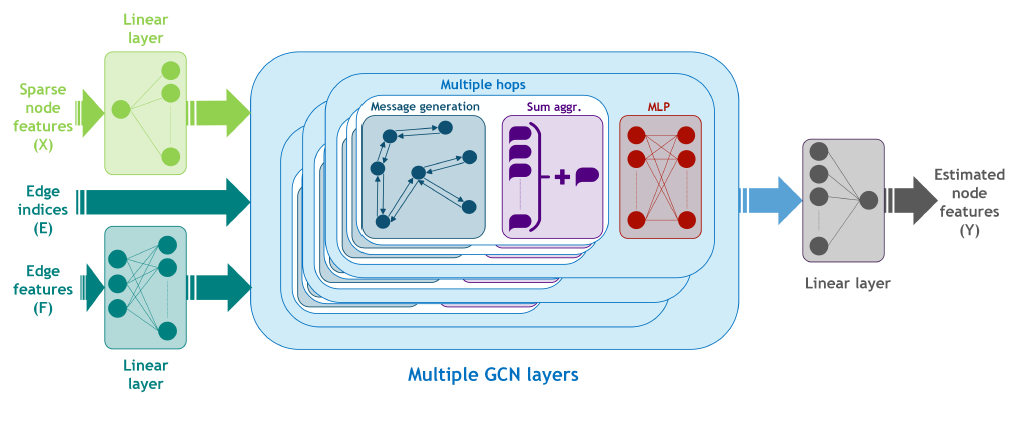

In [27]:
class GCN_layer(MessagePassing):
    def __init__(self, latent_dim):
        super().__init__(aggr = 'add')

        self.activation = nn.SELU()
        self.message_project = nn.Linear(latent_dim * 2, latent_dim, bias=False)


    def message(self, x_i, x_j, edge_attr):
        h_hat_edge = edge_attr + torch.abs(x_j - x_i)
        edge_attr = h_hat_edge
        concat = torch.cat([x_j, h_hat_edge], dim=1)
        concat_proj = self.message_project(concat)
        return self.activation(concat_proj)

    def update(self, aggr_out, x):
        return x+aggr_out

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index=edge_index, x=x, edge_attr=edge_attr)


In [28]:
class mlp(nn.Module):
    def __init__(self, latent_dim, n_levels):
        super().__init__()
        layers = []
        for i in range(n_levels-1):
            layers.append(nn.Linear(latent_dim, latent_dim, bias=False))
            layers.append(nn.SELU())
        layers.append(nn.Linear(latent_dim, latent_dim, bias=False))
        self.full_mlp = nn.Sequential(*layers)

    def forward(self, data):
        return self.full_mlp(data)



In [29]:
class GCN_Model(nn.Module):
    def __init__(self, latent_dim=latent_dim, in_dim_edges=4, in_dim_nodes=1, num_gcn_layers=N_GCN_LAYERS, multihop = MULTIHOP, mlp_levels = N_MLP_LEVELS):
        super().__init__()
        self.multihop = multihop
        # Project in space of same dimension
        self.node_projection = nn.Linear(in_dim_nodes, latent_dim, bias=False)
        self.edge_projection = nn.Linear(in_dim_edges, latent_dim, bias=False)

        # m-GCN layers
        self.mgcn_layers= nn.ModuleList()
        self.mlp_layers = nn.ModuleList()
        for i in range(num_gcn_layers):
            self.mgcn_layers.append(GCN_layer(latent_dim))
            if i%multihop ==0:
                self.mlp_layers.append(mlp(latent_dim, mlp_levels))

        # Output layer gamma
        self.gamma = nn.Linear(latent_dim, in_dim_nodes)

    def forward(self, data):
        node_data, edge_attr, edge_index = data.x.unsqueeze(1), data.edge_attr, data.edge_index

        h_node = self.node_projection(node_data)
        h_edge = self.edge_projection(edge_attr)

        i = 0
        for message_passing_level , j in zip(self.mgcn_layers, range(len(self.mgcn_layers))):
            h_node = message_passing_level(h_node, edge_index, h_edge)
            if j % self.multihop ==0:
                h_node = self.mlp_layers[i](h_node)
                i+=1

        y_out = self.gamma(h_node)

        return y_out

## Loss

The loss is given by the $L_1$ loss:

\begin{equation}
    \mathcal{L}(y, \hat y) = \frac {1}{S \cdot N} \sum_{i=1}^S \sum_{v=1}^N |y_{iv}-\hat y_{iv}|
\end{equation}


where $y$ is the ground truth, $N$ the number of nodes and $S$ the number of samples in the mini-batch.

In [30]:
def L1_Loss(y, y_hat):
    return torch.mean(torch.abs(y - y_hat))

The model is then trained with defined parameters.

In [69]:

class Trainer():
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.chk_name = "saved_model_"
        self.iteration = 0
        self.train_losses = []
        self.valid_losses = []

    def save_model(self, model_name = "mhop"):
        '''
        Method used for save the model.
        '''
        print("Model saved")
        date = datetime.today().strftime('%Y-%m-%d_%H-%M')
        torch.save(self.model.state_dict(),
                    os.path.join(CHECKPOINTS_PATH, model_name + "__" + self.chk_name + "__" + date + '.pt'))

    def load_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=DEVICE)
        self.model.load_state_dict(checkpoint)
        self.model.eval()
        print("Modello caricato correttamente")

    def train(self, train_dataset, validation_dataset, epochs=EPOCHS):
        # Number of samples in the training set
        self.n_sample = len(train_dataset)

        valid_loss = 1000.0

        # # List of training losses
        self.train_losses = []

        # # List of validation losses
        self.valid_losses = []

        #cycle on epochs
        for epoch in tqdm(range(epochs), desc = "Epochs", leave = False):
            epoch_loss = 0
            self.model.train()

            #cycle on batches
            batch_pbar = tqdm(train_dataset, desc = "Training - Batch", leave = False)
            for batch in batch_pbar:
                self.optimizer.zero_grad()

                input_data = batch["input"].to(DEVICE)
                groundtruth = batch["groundtruth"].x.to(DEVICE)
                prediction = self.model(input_data)

                # Squeeze the prediction tensor to match the groundtruth shape
                prediction = prediction.squeeze()

                # Compute loss
                sample_loss = L1_Loss(prediction, groundtruth)

                # compute gradient
                sample_loss.backward()

                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': valid_loss, 'training_loss': sample_loss.item()})#, 'patience': self.counter})

            # compute epoch loss
            avg_epoch_loss = epoch_loss / len(train_dataset)
            self.train_losses.append(avg_epoch_loss)
            if(epoch%50 == 0):
                self.save_model()

            # validation loss
            valid_loss = self.evaluate(validation_dataset)

            # print('val_loss', valid_loss)
            self.valid_losses.append(valid_loss)

            print("train:", avg_epoch_loss, "\t validation:", valid_loss)

        return self.train_losses, self.valid_losses

    def evaluate(self, validation_dataset):
        valid_loss = 0.0
        self.model.eval()
        with torch.no_grad():
            batch_pbar = tqdm(validation_dataset, desc = "Validation - Batch", leave = False)
            for  batch in batch_pbar:

                input_data = batch["input"].to(DEVICE)
                groundtruth = batch["groundtruth"].x.to(DEVICE)
                prediction = self.model(input_data)

                # Squeeze the prediction tensor to match the groundtruth shape
                prediction = prediction.squeeze()

                # Compute loss
                sample_loss = L1_Loss(prediction, groundtruth)
                valid_loss += sample_loss.tolist()

                batch_pbar.set_postfix({'validation_loss': sample_loss.tolist()})
        avg_valid_loss = valid_loss / len(validation_dataset)
        return avg_valid_loss



    def test(self, test_dataset):
        self.model.eval()
        metrics = {}
        MSE_losses = 0
        L1_losses = 0

        nn_L1_losses = 0

        sensor_ind = 0
        not_sensor_ind = 6

        sensor_data_real = []
        not_sensor_data_real = []

        sensor_data_prediction = []
        not_sensor_data_prediction = []


        mean_error = None
        first_iteration = True
        with torch.no_grad():
            batch_pbar = tqdm(test_dataset, desc = "Test - Batch", leave = False)
            for batch in batch_pbar:


                input_data = batch["input"].to(DEVICE)
                groundtruth = batch["groundtruth"].x.to(DEVICE)
                prediction = self.model(input_data)


                # Squeeze the prediction tensor to match the groundtruth shape
                prediction = prediction.squeeze()



                MSE_loss = F.mse_loss(prediction, groundtruth)
                MSE_losses += MSE_loss.item()

                l1_loss =L1_Loss(prediction, groundtruth)
                L1_losses += l1_loss.item()

                not_norm_groundtruth = data_load_helper.inverse_normalize_torch_data_nodes(groundtruth)
                not_norm_pediction =  data_load_helper.inverse_normalize_torch_data_nodes(prediction)

                if first_iteration:
                    mean_error = torch.zeros_like(groundtruth)
                    groundtruth_example = not_norm_groundtruth.squeeze()
                    prediction_example = not_norm_pediction.squeeze()

                nn_l1_loss =L1_Loss(not_norm_pediction, not_norm_groundtruth)
                nn_L1_losses += nn_l1_loss.item()

                mean_error += torch.abs(not_norm_groundtruth.squeeze() - not_norm_pediction.squeeze() )
                sensor_data_real.append( not_norm_groundtruth.squeeze()[sensor_ind].item())
                not_sensor_data_real.append(not_norm_groundtruth.squeeze()[not_sensor_ind].item())

                sensor_data_prediction.append(not_norm_pediction.squeeze()[sensor_ind].item())
                not_sensor_data_prediction.append(not_norm_pediction.squeeze()[not_sensor_ind].item())

        metrics['MSE_mean'] = MSE_losses / len(test_dataset)
        metrics['L1_mean'] = L1_losses / len(test_dataset)
        metrics['nn_L1_mean'] = nn_L1_losses / len(test_dataset)
        metrics['mean_error_sensors'] = mean_error/ len(test_dataset)
        metrics["sensor_data_real"] = sensor_data_real
        metrics["not_sensor_data_real"] = not_sensor_data_real
        metrics["sensor_data_prediction"] = sensor_data_prediction
        metrics["not_sensor_data_prediction"] = not_sensor_data_prediction
        return metrics, groundtruth_example, prediction_example

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [33]:
model = GCN_Model().to(DEVICE)
# print(model)

optimizer = torch.optim.Adam( params=model.parameters(), lr=1e-6, weight_decay=WEIGHT_DECAY)

trainer = Trainer(model, optimizer)

In [27]:
train_losses, valid_losses = trainer.train(train_dataloader, val_dataloader, EPOCHS)

Epochs:   0%|          | 0/600 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/432 [00:00<?, ?it/s]

Model saved


Validation - Batch:   0%|          | 0/144 [00:00<?, ?it/s]

train: 1.0277437820202775 	 validation: 0.8389693618648582


Training - Batch:   0%|          | 0/432 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/144 [00:00<?, ?it/s]

train: 0.7740016278845293 	 validation: 0.7021690780917803


Training - Batch:   0%|          | 0/432 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/144 [00:00<?, ?it/s]

train: 0.6770934523945605 	 validation: 0.6314538744174771


Training - Batch:   0%|          | 0/432 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/144 [00:00<?, ?it/s]

train: 0.6181041804590711 	 validation: 0.5844614093916284


Training - Batch:   0%|          | 0/432 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Remove from memory the datasets
# del val_dataset
# del train_dataset

# gc.collect()

## Results and analysis.


The following graphs show the trend in losses for the training and validation datasets of a 600-epoch model training.

The graphs clearly show that training loss and validation loss decrease steadily and closely accompany each other throughout the training process. This joint decay is a strong indicator that the model is generalising well and is not undergoing significant overfitting.

A specific trend can be seen by looking at the loss plotted against the logarithm of the number of epochs (graph on the right). The loss shows a linear decline against the logarithmic scale of the epochs.

Given the continuous downward trend observed in both curves and the constant linear decay in the logarithmic scale graph, it is reasonable to assume that the model's performance was still improving. Therefore, it would have been possible to achieve a further reduction in loss by training the model for a greater number of epochs.



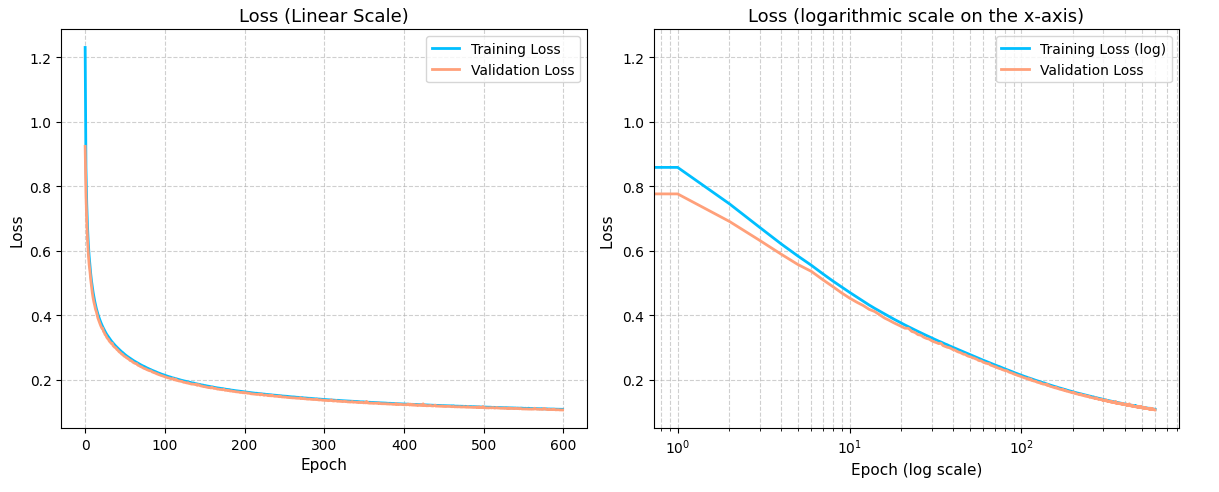

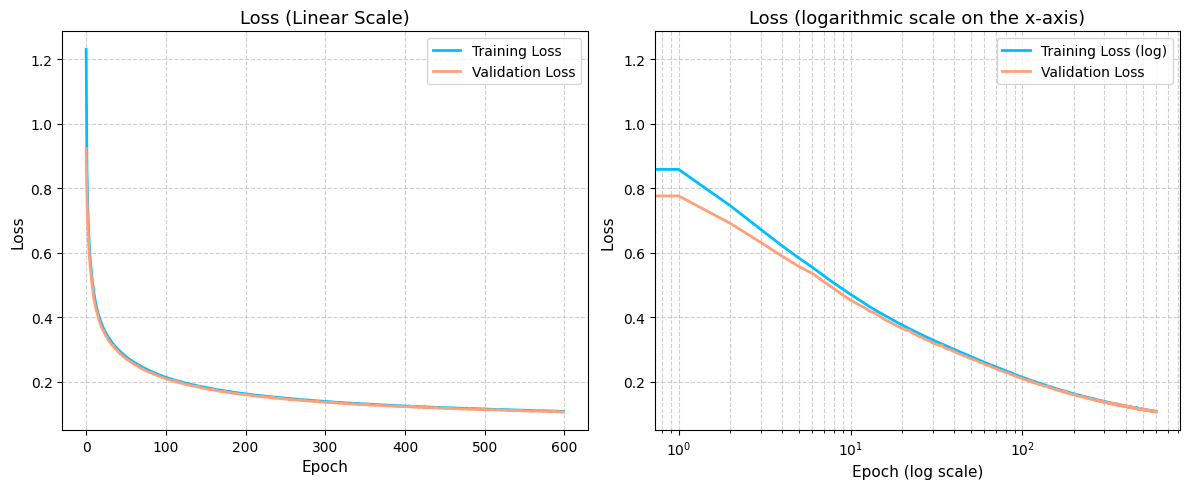

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Grafico a sinistra (scala lineare)
axes[0].plot(trainer.train_losses, label='Training Loss', color='deepskyblue', linewidth=2)
axes[0].plot(trainer.valid_losses, label='Validation Loss', color='lightsalmon', linewidth=2)
axes[0].set_title('Loss (Linear Scale)', fontsize=13)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Grafico a destra (scala logaritmica)
axes[1].plot(trainer.train_losses, label='Training Loss (log)', color='deepskyblue', linewidth=2)
axes[1].plot(trainer.valid_losses, label='Validation Loss', color='lightsalmon', linewidth=2)
axes[1].set_xscale('log')
axes[1].set_title('Loss (logarithmic scale on the x-axis)', fontsize=13)
axes[1].set_xlabel('Epoch (log scale)', fontsize=11)
axes[1].set_ylabel('Loss ', fontsize=11)
axes[1].grid(True, which="both", linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

Measurements were then carried out on the test dataset.

In [34]:
test_data = data_load_helper.load_data(pressure_data_path, "test")
second_period_data = data_load_helper.load_data(pressure_data_path, "second_period")
test_dataset = OptimizedGraphDataset(root_dataset_path_val, test_data, masked_indices, edge_index, edges_features)
second_period_dataset = OptimizedGraphDataset(root_dataset_path_train, second_period_data, masked_indices, edge_index, edges_features)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
secon_period_dataloader = DataLoader(second_period_dataset, batch_size=1, shuffle=False)

Selected tets data, 20% of 1st month. 576 samples.
Selected 2nd and 3rd months. 5760 samples.
torch.Size([909, 4]) torch.Size([4]) torch.Size([4])
torch.Size([909, 4]) torch.Size([4]) torch.Size([4])


In [75]:
# Load a pre-trained model:
# Drive path
model_path_multihop =project_folder + "Model/mhop__saved_model_600_epochs.pt"
trainer = Trainer(model, optimizer)
trainer.load_model(model_path_multihop)
test_measures, gt_example, prediction_example = trainer.test(test_dataloader)



Modello caricato correttamente


Test - Batch:   0%|          | 0/576 [00:00<?, ?it/s]

Below is an example of a prediction and the corresponding ground truth. The data are shown in the original scale (the inverse transformation of the initial normalisation has been applied).

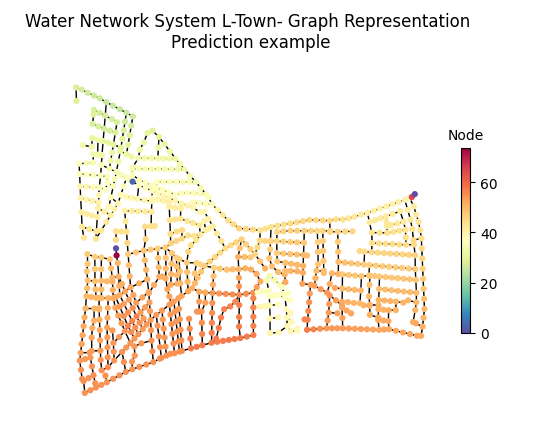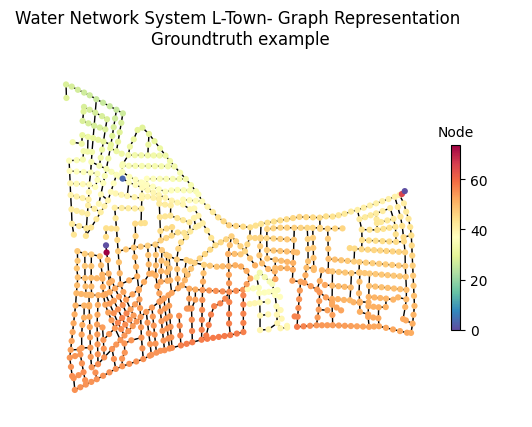

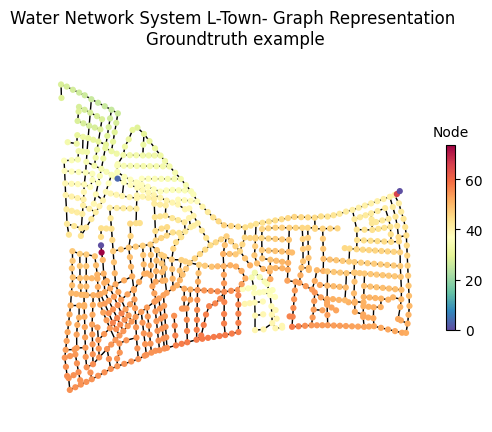

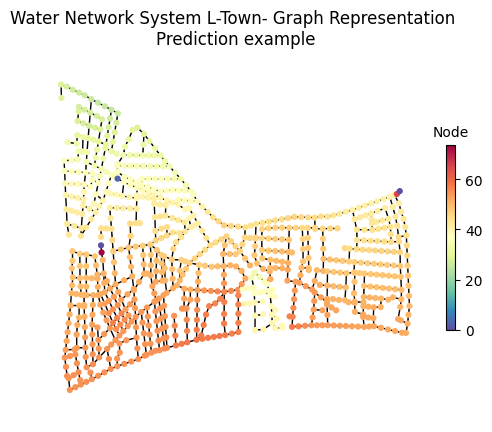

In [36]:
color_map_gt = {}
color_map_prediction = {}

for (node_name, node), value_gt, value_pred  in zip(wn_model.nodes(), gt_example.detach().cpu().numpy(), prediction_example.detach().cpu().numpy()):
    color_map_gt[node_name] = value_gt
    color_map_prediction[node_name] = value_pred

pos = wntr.graphics.plot_network(
    wn_model,
    node_attribute=color_map_gt,
    title="Water Network System L-Town- Graph Representation \nGroundtruth example"
)

pos = wntr.graphics.plot_network(
    wn_model,
    node_attribute=color_map_prediction,
    title="Water Network System L-Town- Graph Representation \nPrediction example"
)



The attached figure shows the mean absolute error calculated over the entire test data set for each node in the network. The error values reported here refer to denormalised data and provide a measure of the model's inaccuracy in the original physical units of the sensors.

Overall, the distribution of errors confirms that the model approximates the missing data well, suggesting that the graph neural network (GNN) effectively exploits the known sensor information and the topological structure of the graph to accurately infer the missing values.

Furthermore, the low error values on the test model also suggest good generalisation ability of the model.

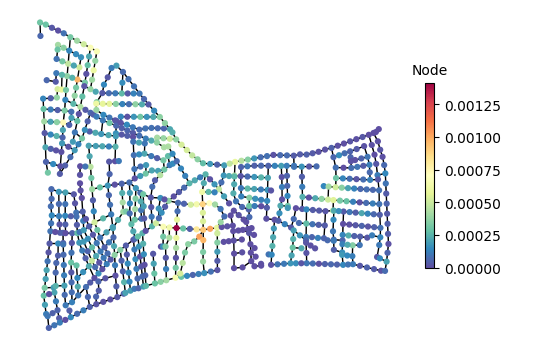

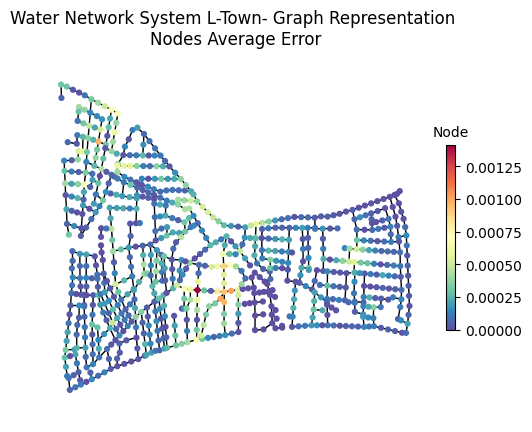

In [37]:
color_map_error = {}
for (node_name, node), valore in zip(wn_model.nodes(), test_measures['mean_error_sensors'].detach().cpu().numpy()):
    color_map_error[node_name] = valore

# Representation of the network: in green the nodes with sensors, in red all the others
pos = wntr.graphics.plot_network(wn_model, node_attribute  = color_map_error, title="Water Network System L-Town- Graph Representation \nNodes Average Error")


Below the aggregate performance metrics on the test dataset.


In [40]:
print("The Mean Absolute Error referred to normalized data is:", test_measures['L1_mean'])
print("The Mean Absolute Error referred to not normalized data is:", test_measures['nn_L1_mean'])
print("The Mean Square Error referred to normalized data is:", test_measures['MSE_mean'])


The Mean Absolute Error referred to normalized data is: 0.29075348674733603
The Mean Absolute Error referred to not normalized data is: 0.11102309813981669
The Mean Square Error referred to normalized data is: 0.19249227650774023


Following the article measurements, a performance test was conducted over a two-month period immediately subsequent to the model's training phase. The accompanying figure displays the true pressure values and the model's predictions over this period for two representative cases: a sensored node and an unsensored node. The data presented here are based on denormalized pressure values.

It is evident that the prediction curve closely follows the overall oscillations and temporal trends of the true pressure data for both node types.
Despite the good tracking performance, errors are visibly present at maximum pressure values.

As expected, the prediction for the sensored node generally exhibits a higher fidelity to the true data.


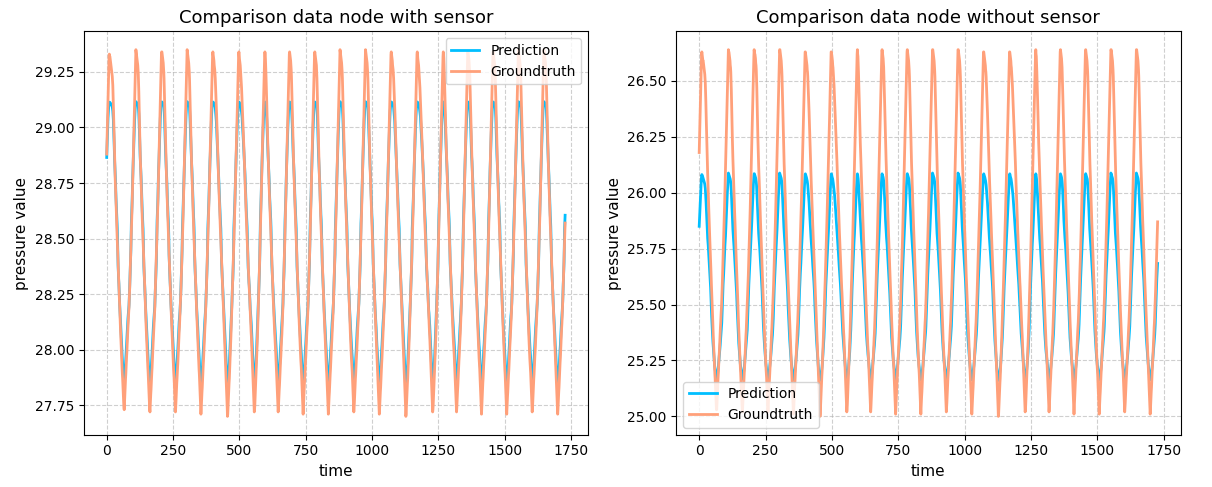



Test - Batch:   0%|          | 0/1728 [00:00<?, ?it/s]

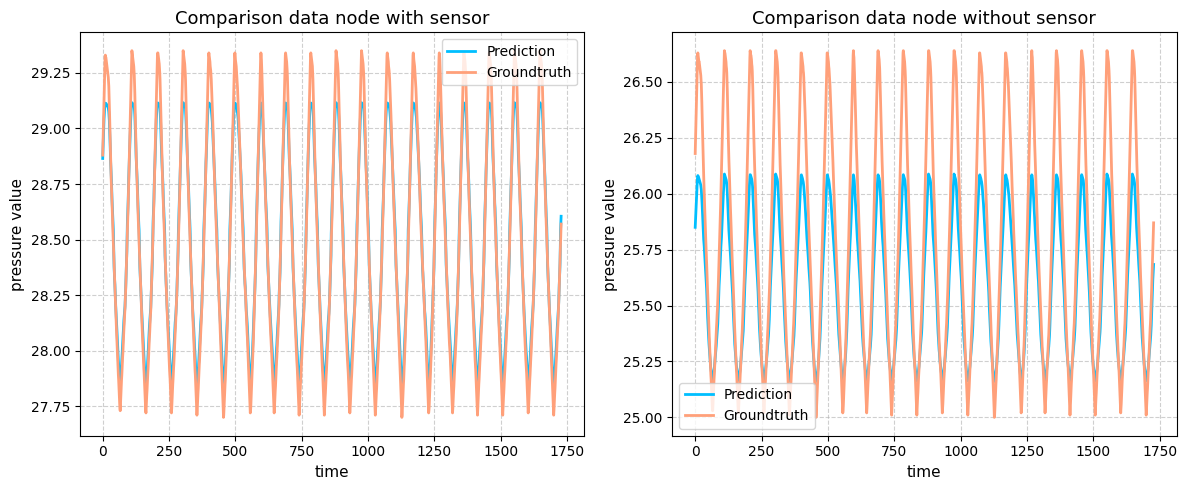

In [74]:
test_measures, _, _ = trainer.test(second_period_dataset)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Grafico a sinistra (scala lineare)
axes[0].plot(test_measures['sensor_data_prediction'], label='Prediction', color='deepskyblue', linewidth=2)
axes[0].plot(test_measures['sensor_data_real'], label='Groundtruth', color='lightsalmon', linewidth=2)
axes[0].set_title('Comparison data node with sensor', fontsize=13)
axes[0].set_xlabel('time', fontsize=11)
axes[0].set_ylabel('pressure value', fontsize=11)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Grafico a destra (scala logaritmica)
axes[1].plot(test_measures['not_sensor_data_prediction'], label='Prediction', color='deepskyblue', linewidth=2)
axes[1].plot(test_measures['not_sensor_data_real'], label='Groundtruth', color='lightsalmon', linewidth=2)
axes[1].set_title('Comparison data node without sensor', fontsize=13)
axes[1].set_xlabel('time', fontsize=11)
axes[1].set_ylabel('pressure value', fontsize=11)
axes[1].grid(True, which="both", linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

## Limitations and reflections


The main limitations encountered during the model training are computational in nature, as the network requires a significant amount of time to train, which exhausts the available resources.

The current network architecture does not account for two important aspects that could improve data prediction: the temporal dimension and the physical nature of the system.

Regarding the temporal dimension, water distribution systems (WDS) are characterized by strong seasonality and daily cyclical variations. The current network does not capture in explicit way these temporal patterns. To address this, the dataset could be expanded, and it would be beneficial for network monitoring purposes to predict the system’s future state. Forecasting future states would allow for timely detection of leaks or more effective control of flows. Additionally, given the seasonality of the data, it would be advisable to train the network over periods of at least one year or to sample data throughout the entire year to ensure representative coverage of seasonal variations.

Concerning the physical aspect, modifications could be implemented to incorporate domain-specific constraints. For example, physical knowledge about the governing laws of WDS could be embedded into the model by adding physics-informed components to the loss function, thereby guiding the network to respect known physical principles.


## References.


### Dataset:

*   https://battledim.ucy.ac.cy/
*   Vrachimis, S. G., D. G. Eliades, R. Taormina, Z. Kapelan, A. Ostfeld, S. Liu, M. Kyriakou, P. Pavlou, M. Qiu, and M. M. Polycarpou. 2022. “Battle of the leakage detection and isolation methods.” https://doi.org/10.1061/(ASCE)WR.1943-5452.0001601.
*   https://github.com/HammerLabML/GCNs_for_WDS/tree/main
*   https://usepa.github.io/WNTR/

### Graphs and GNN:

*   Scardapane, S. "Alice's Adventures in a Differentiable Wonderland -- Volume I, A Tour of the Land". https://arxiv.org/abs/2404.17625
*   Diestel, R. "Graph Theory". (5th. ed.). Springer Publishing Company, Incorporated.
*   https://pytorch-geometric.readthedocs.io/en/latest/index.html
*   https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets
*   https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing
*   https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html


### Model:

*   Ashraf, I., Hermes, L., Artelt, A.,  Hammer B. "Spatial Graph Convolution Neural Networks for Water Distribution Systems". 2002 https://arxiv.org/abs/2211.09587
*   https://docs.pytorch.org/docs/stable/generated/torch.nn.SELU.html

